In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import librosa
import math
import os
from tqdm import tqdm

In [45]:
import tensorflow as tf
from tensorflow.keras import layers 

In [3]:
def plot_acc(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.show()

In [4]:
sample_rate = 22050
num_segments = 10
sample_per_segment = int(sample_rate*30 / num_segments)
print(sample_per_segment)

66150


In [5]:
dataset_dir = "../Data/genres_original/"

In [16]:
file_path = "../Data/genres_original/hiphop/hiphop.00003.wav"
y, sr = librosa.load(file_path, sr=sample_rate)
data = {"labels": [], "mfcc": [], "chroma": [], "zcr": []}

In [17]:
for n in range(num_segments):
    mfcc = librosa.feature.mfcc(y=y[sample_per_segment*n: sample_per_segment*(n+1)], sr=sample_rate, n_mfcc=40, n_fft=2048, hop_length=512)
    mfcc = mfcc.T
    
    if(len(mfcc) == math.ceil(sample_per_segment / 512)):
        data["mfcc"].append(mfcc.tolist())
        data["labels"].append("hiphop")

In [18]:
np.array(data['mfcc']).shape

(10, 130, 40)

In [19]:
for n in range(num_segments):
    chroma = librosa.feature.chroma_stft(y=y[sample_per_segment*n: sample_per_segment*(n+1)], sr=sample_rate, n_fft=2048, hop_length=512)
    chroma = chroma.T
    
    if(len(chroma) == math.ceil(sample_per_segment / 512)):
        data["chroma"].append(chroma.tolist())

In [20]:
np.array(data['chroma']).shape

(10, 130, 12)

In [22]:
for n in range(num_segments):
    zcr = librosa.feature.zero_crossing_rate(y=y[sample_per_segment*n: sample_per_segment*(n+1)], frame_length=2048, hop_length=512)
    zcr = zcr.T
    
    if(len(zcr) == math.ceil(sample_per_segment / 512)):
        data["zcr"].append(zcr.tolist())

In [23]:
np.array(data['zcr']).shape

(10, 130, 1)

In [25]:
label_idx = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 
             'reggae': 8, 'rock': 9}

In [26]:
data = {"labels": [], "mfcc": [], "chroma": [], "zcr": []}
sample_rate = 22050
sample_per_segment = int(sample_rate*30 / num_segments)
for label_idx, (dirpath, dirname, filenames) in enumerate(os.walk(dataset_dir)):
    if(dirpath == dataset_dir):
        continue
    
    for f in tqdm(sorted(filenames)):
        if not f.endswith('.wav'):
            continue
        file_path = str(str(dirpath).split("\\")[-1]) + '/' + str(f)
        
        try:
            y, sr = librosa.load(file_path, sr=sample_rate)
        except:
            continue
        for n in range(num_segments):
            mfcc = librosa.feature.mfcc(y=y[sample_per_segment*n: sample_per_segment*(n+1)], 
                                       sr=sample_rate, n_mfcc=40, n_fft=2048, hop_length=512)
            mfcc = mfcc.T
            if(len(mfcc) == math.ceil(sample_per_segment / 512)):
                data["mfcc"].append(mfcc.tolist())
                data["labels"].append(label_idx-1)
                
        for n in range(num_segments):
            chroma = librosa.feature.chroma_stft(y=y[sample_per_segment*n: sample_per_segment*(n+1)], sr=sample_rate, n_fft=2048, hop_length=512)
            chroma = chroma.T

            if(len(chroma) == math.ceil(sample_per_segment / 512)):
                data["chroma"].append(chroma.tolist())
                
        for n in range(num_segments):
            zcr = librosa.feature.zero_crossing_rate(y=y[sample_per_segment*n: sample_per_segment*(n+1)], frame_length=2048, hop_length=512)
            zcr = zcr.T

            if(len(zcr) == math.ceil(sample_per_segment / 512)):
                data["zcr"].append(zcr.tolist())

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:19<00:14,  3.19it/s]C:\Users\nihal\Anaconda3\envs\gpuenv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.83it/s]


In [27]:
len(data)

4

In [28]:
len(data['mfcc']), len(data['labels']), len(data['chroma']), len(data['zcr'])

(9986, 9986, 9986, 9986)

In [32]:
x1 = np.array(data['mfcc'])
x2 = np.array(data['chroma'])
x3 = np.array(data['zcr'])
y = np.array(data['labels'])

In [33]:
x1.shape, x2.shape, x3.shape, y.shape

((9986, 130, 40), (9986, 130, 12), (9986, 130, 1), (9986,))

In [57]:
x1 = x1.reshape(x1.shape[0], x1.shape[1], x1.shape[2], 1)
x2 = x2.reshape(x2.shape[0], x2.shape[1], x2.shape[2], 1)

In [62]:
x3 = x3.reshape(x3.shape[0], x3.shape[1])

In [34]:
from sklearn.model_selection import train_test_split

In [63]:
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, test_size=0.20, random_state=42)
x2_train, x2_test, _, _ = train_test_split(x2, y, test_size=0.20, random_state=42)
x3_train, x3_test, _, _ = train_test_split(x3, y, test_size=0.20, random_state=42)

In [64]:
y_train.shape, y_test.shape

((7988,), (1998,))

In [65]:
x1_train.shape, x2_train.shape, x3_test.shape

((7988, 130, 40, 1), (7988, 130, 12, 1), (1998, 130))

In [66]:
Y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [67]:
Y_train.shape, Y_test.shape

((7988, 10), (1998, 10))

In [68]:
Y_train[Y_train == 10] = 9
Y_test[Y_test == 10] = 9

In [69]:
Y_train.shape, Y_test.shape

((7988, 10), (1998, 10))

In [54]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, concatenate, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [96]:
input_mfcc = Input(shape=(130, 40, 1))
input_chroma = Input(shape=(130, 12, 1))
input_zcr = Input(shape=(130))

# MFCC
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_mfcc)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Dropout(0.3)(x)
x = BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = Model(inputs=input_mfcc, outputs=x)

# Chroma
y = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_chroma)
y = layers.MaxPooling2D(2, padding='same')(y)
y = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(y)
y = layers.MaxPooling2D(2, padding='same')(y)
y = layers.Dropout(0.3)(y)
y = layers.Conv2D(128, (3, 3), activation='relu', padding='valid')(y)
y = layers.MaxPooling2D(2, padding='same')(y)
y = layers.Dropout(0.3)(y)
y = BatchNormalization()(y)
y = layers.GlobalAveragePooling2D()(y)
y = Model(inputs=input_chroma, outputs=y)

# ZCR
z = layers.Dense(64)(input_zcr)
z = layers.Dropout(0.3)(z)
z = layers.Dense(64)(z)
z = BatchNormalization()(z)
z = Model(inputs=input_zcr, outputs=z)

# Concat
combined = concatenate([x.output, y.output, z.output])

m = Dense(256, activation="relu")(combined)
m = Dropout(0.5)(m)
m = Dense(128, activation='relu')(m)
m = Dropout(0.3)(m)
m = BatchNormalization()(m)
m = Dense(10, activation="softmax")(m)

model = Model(inputs=[x.input, y.input, z.input], outputs=m)
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 130, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_26 (InputLayer)          [(None, 130, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 130, 40, 32)  320         ['input_25[0][0]']               
                                                                                           

                                                                                                  
 batch_normalization_25 (BatchN  (None, 128)         512         ['dropout_45[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 dense_28 (Dense)               (None, 10)           1290        ['batch_normalization_25[0][0]'] 
                                                                                                  
Total params: 500,490
Trainable params: 499,594
Non-trainable params: 896
__________________________________________________________________________________________________


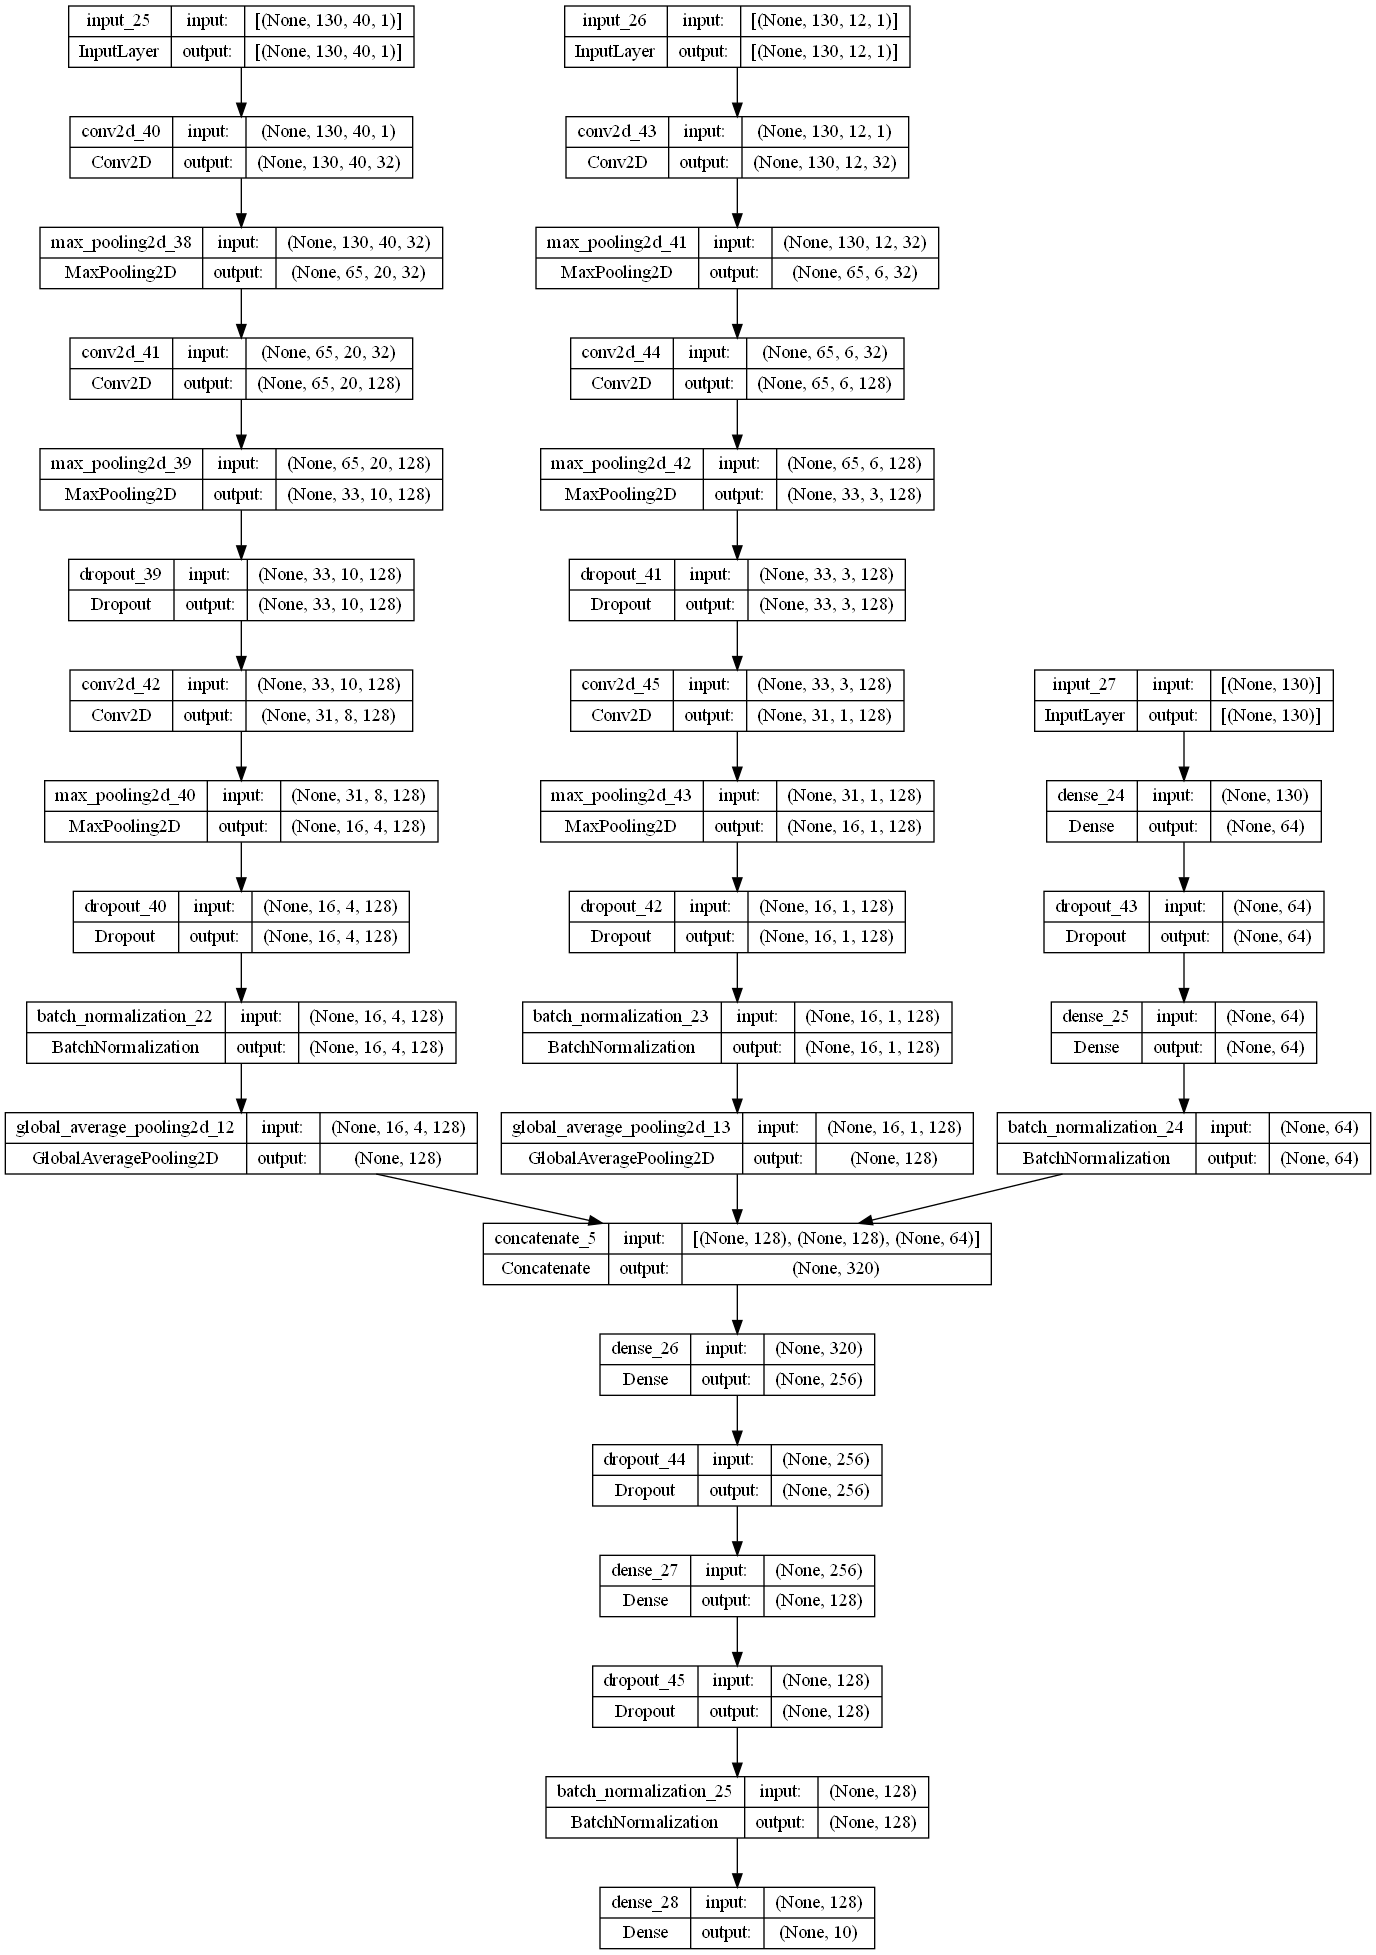

In [97]:
tf.keras.utils.plot_model(model, to_file="cnn_based_combined_v2.png", show_shapes=True)

In [98]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
history = model.fit(x=[x1_train,
                       x2_train,
                       x3_train, ], y= Y_train, validation_split=0.2, epochs=60, batch_size=64, callbacks=[reduce_lr])

Epoch 1/60
100/100 [==============================] - 6s 45ms/step - loss: 1.9592 - accuracy: 0.3282 - val_loss: 1.4907 - val_accuracy: 0.4437 - lr: 0.0010
Epoch 2/60
100/100 [==============================] - 4s 43ms/step - loss: 1.4263 - accuracy: 0.4844 - val_loss: 1.5115 - val_accuracy: 0.4074 - lr: 0.0010
Epoch 3/60
100/100 [==============================] - 4s 42ms/step - loss: 1.2276 - accuracy: 0.5623 - val_loss: 1.3482 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 4/60
100/100 [==============================] - 4s 42ms/step - loss: 1.0837 - accuracy: 0.6155 - val_loss: 1.0466 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 5/60
100/100 [==============================] - 4s 41ms/step - loss: 0.9767 - accuracy: 0.6601 - val_loss: 1.3613 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 6/60
100/100 [==============================] - 4s 41ms/step - loss: 0.8818 - accuracy: 0.6887 - val_loss: 1.6143 - val_accuracy: 0.4681 - lr: 0.0010
Epoch 7/60
100/100 [==============================] - 4s 42ms/st

100/100 [==============================] - 4s 42ms/step - loss: 0.0704 - accuracy: 0.9792 - val_loss: 0.3599 - val_accuracy: 0.8861 - lr: 1.6000e-06
Epoch 53/60
100/100 [==============================] - 4s 42ms/step - loss: 0.0646 - accuracy: 0.9839 - val_loss: 0.3573 - val_accuracy: 0.8874 - lr: 1.6000e-06
Epoch 54/60
100/100 [==============================] - 4s 42ms/step - loss: 0.0671 - accuracy: 0.9831 - val_loss: 0.3567 - val_accuracy: 0.8867 - lr: 1.6000e-06
Epoch 55/60
100/100 [==============================] - 4s 42ms/step - loss: 0.0711 - accuracy: 0.9772 - val_loss: 0.3558 - val_accuracy: 0.8880 - lr: 3.2000e-07
Epoch 56/60
100/100 [==============================] - 4s 42ms/step - loss: 0.0751 - accuracy: 0.9790 - val_loss: 0.3591 - val_accuracy: 0.8880 - lr: 3.2000e-07
Epoch 57/60
100/100 [==============================] - 4s 42ms/step - loss: 0.0716 - accuracy: 0.9793 - val_loss: 0.3577 - val_accuracy: 0.8880 - lr: 3.2000e-07
Epoch 58/60
100/100 [=========================

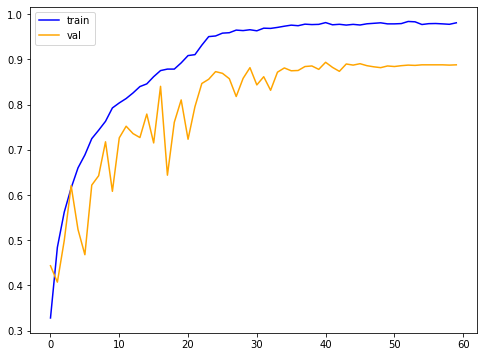

In [99]:
plot_acc(history)

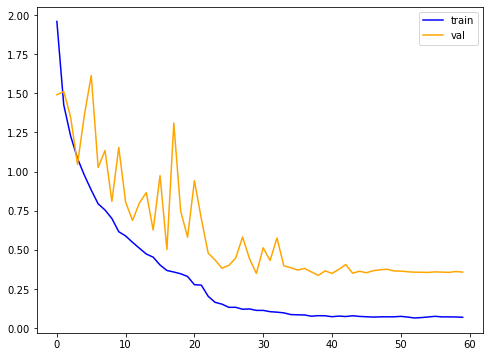

In [100]:
plot_loss(history)

In [101]:
model.save("../Models/CNN_Combined")

INFO:tensorflow:Assets written to: ../Models/CNN_Combined\assets


INFO:tensorflow:Assets written to: ../Models/CNN_Combined\assets
